# Bradfords Air Quality Analysis(winter)



Air pollution is a significant environmental and public health concern, particularly in urban areas like Bradford. Fine particulate matter, such as **PM2.5** and **PM10**, can penetrate deep into the lungs and bloodstream, contributing to respiratory and cardiovascular diseases. Understanding the distribution and variation of these pollutants is essential for effective public health planning and environmental policy.



This report has been prepared in response to a request from **Elected Members of Bradford Council**, who seek a clearer understanding of local air quality during this winter period. The goal is to analyze and communicate insights derived from particulate matter data, supported by additional contextual information where appropriate.

The primary objectives of this analysis are to:
- **Examine** the levels and patterns of PM2.5 and PM10 across different monitoring stations in Bradford.
- **Identify** trends, exceedances, and anomalies in the data.
- **Provide insights** that help Council Officers and Elected Members make informed decisions to improve public health and environmental outcomes.


## 1 Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install meteostat
!pip install feature-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 5.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
from meteostat import Point, Hourly
from datetime import datetime
#importing all the required packages

## 2. Data Ingestion & Cleaning Pipeline

In [4]:
def load_and_format_data(filepath):# loading the file, dropping the unit row, and flattening column headers
    df = pd.read_excel(filepath, header=[2, 3])
    df = df.drop(index=[0]).reset_index(drop=True)
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    return df

def clean_datetime_column(df, datetime_col='Date Time_Unnamed: 0_level_1'):#renaming datetime column and setting it as index
    df = df.rename(columns={datetime_col: 'datetime'})
    df['datetime'] = pd.to_datetime(df['datetime'], format="%H:%M %d/%m/%Y", errors='coerce')
    df = df[df['datetime'].notna()].copy()
    df.set_index('datetime', inplace=True)
    return df

def clean_numeric_columns(df):#converting all columns to numeric,also replacing negative values with NaN
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].where(df[col] >= 0, np.nan)
    return df

def summarize_nulls(df):
    nulls = df.isnull().sum().to_frame(name='Null Count')
    nulls['% Missing'] = (nulls['Null Count'] / len(df)) * 100
    return nulls

In [5]:
#load the dataset
filepath_new = '/content/drive/MyDrive/Multi Station Report 01_11_2024.xlsx'
df_new_raw = load_and_format_data(filepath_new)#clean the dataset
df_new_cleaned = clean_numeric_columns(clean_datetime_column(df_new_raw))
df_new_cleaned.head()

,Bradford Keighley_PM10 grav,Bradford Keighley_PM2.5,Bradford Tong Street_PM10 grav,Bradford Tong Street_PM2.5,Bradford Treadwell Mills_PM10 grav,Bradford Treadwell Mills_PM2.5
datetime,,,,,,
2024-11-01 01:00:00,6.2,5.2,10.2,5.8,NaN,NaN
2024-11-01 02:00:00,1.0,NaN,2.1,NaN,NaN,NaN
2024-11-01 03:00:00,6.1,4.6,7.3,4.3,NaN,NaN
2024-11-01 04:00:00,5.8,4.2,11.6,7.8,NaN,NaN
2024-11-01 05:00:00,2.8,1.0,2.4,NaN,NaN,NaN


##  3. Exploratory Data Analysis(EDA)

In [6]:
summarize_nulls(df_new_cleaned)#missing values

,Null Count,% Missing
Bradford Keighley_PM10 grav,81,4.573687
Bradford Keighley_PM2.5,124,7.001694
Bradford Tong Street_PM10 grav,405,22.868436
Bradford Tong Street_PM2.5,554,31.281762
Bradford Treadwell Mills_PM10 grav,1150,64.935065
Bradford Treadwell Mills_PM2.5,1150,64.935065


In [7]:
df_new_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
Bradford Keighley_PM10 grav,1690.0,13.926568,15.913931,0.0,5.7,10.00,17.3,261.0
Bradford Keighley_PM2.5,1647.0,9.731815,9.603863,0.0,3.5,6.50,12.8,66.6
Bradford Tong Street_PM10 grav,1366.0,13.956369,13.971032,0.0,5.6,9.95,17.7,204.0
Bradford Tong Street_PM2.5,1217.0,8.353328,10.308695,0.0,2.8,5.60,10.4,164.3
Bradford Treadwell Mills_PM10 grav,621.0,15.067311,25.425660,0.3,4.7,8.90,16.6,329.2
Bradford Treadwell Mills_PM2.5,621.0,8.800322,9.449333,0.3,2.8,5.40,10.7,65.7


In [8]:
#printing heatmap to show missing values
ms = df_new_cleaned.isna().astype(int)
fig = px.imshow(
    ms.T,
    aspect='auto',
    labels={'x':'Time', 'y':'Station_Pollutant', 'color':'Missing (1=True)'},
    title='Missing Data Heatmap'
)
fig.update_layout(yaxis_title='Station & Pollutant')
fig.show()

While Bradford Keighley and Tong Street had relatively complete monitoring, Treadwell Mills reported little data — indicating a potential gap in the network during this period. Missing values were preserved to ensure we reflect the actual monitoring coverage.

## 4  Key Findings & Deep-Dive Analysis

### 4.1 Temporal Trends in Particulate Matter

In [9]:
#interactive PM2.5 and PM10 plot to show the concentrations og PM overtime
pm25_cols = [col for col in df_new_cleaned.columns if "PM2.5" in col]
pm10_cols = [col for col in df_new_cleaned.columns if "PM10" in col]

fig_pm25 = go.Figure()
for col in pm25_cols:
    fig_pm25.add_trace(go.Scatter(x=df_new_cleaned.index, y=df_new_cleaned[col],
                                  mode='lines', name=col))
fig_pm25.update_layout(title="PM2.5 Concentrations Over Time by Station",
                       xaxis_title="Time",
                       yaxis_title="PM2.5 (µg/m³)",
                       template="seaborn",
                       height=500)
fig_pm25.show()

fig_pm10 = go.Figure()
for col in pm10_cols:
    fig_pm10.add_trace(go.Scatter(x=df_new_cleaned.index, y=df_new_cleaned[col],
                                  mode='lines', name=col))
fig_pm10.update_layout(title="PM10 Concentrations Over Time by Station",
                       xaxis_title="Time",
                       yaxis_title="PM10 (µg/m³)",
                       template="seaborn",
                       height=500)
fig_pm10.show()

In [10]:
#calculating frequency of exceedance
total_hours = df_new_cleaned.shape[0]
pm25_exceedance_percent = (df_new_cleaned[pm25_cols] > 15).sum() / total_hours * 100
pm10_exceedance_percent = (df_new_cleaned[pm10_cols] > 45).sum() / total_hours * 100

station_summary = pd.DataFrame({
    'Avg PM2.5': df_new_cleaned[pm25_cols].mean(),
    'Max PM2.5': df_new_cleaned[pm25_cols].max(),
    '% Time PM2.5 > 15': pm25_exceedance_percent,
    'Avg PM10': df_new_cleaned[pm10_cols].mean(),
    'Max PM10': df_new_cleaned[pm10_cols].max(),
    '% Time PM10 > 45': pm10_exceedance_percent
})

station_summary

,Avg PM2.5,Max PM2.5,% Time PM2.5 > 15,Avg PM10,Max PM10,% Time PM10 > 45
Bradford Keighley_PM10 grav,NaN,NaN,NaN,13.926568,261.0,2.428007
Bradford Keighley_PM2.5,9.731815,66.6,18.746471,NaN,NaN,NaN
Bradford Tong Street_PM10 grav,NaN,NaN,NaN,13.956369,204.0,2.089215
Bradford Tong Street_PM2.5,8.353328,164.3,9.881423,NaN,NaN,NaN
Bradford Treadwell Mills_PM10 grav,NaN,NaN,NaN,15.067311,329.2,1.298701
Bradford Treadwell Mills_PM2.5,8.800322,65.7,6.437041,NaN,NaN,NaN


Keighley has the highest percentage of PM2.5 exceedance

Treadwell Mills PM10 recorded the highest max (329.2 µg/m³), but has very sparse data.

Tong Street consistently shows mid-to-high levels but fewer exceedances overall

In [11]:
daily_avg = df_new_cleaned.resample('D').mean()

# interactive plot for Daily Avg PM2.5
fig_pm25_avg = go.Figure()
for col in pm25_cols:
    fig_pm25_avg.add_trace(go.Scatter(
        x=daily_avg.index, y=daily_avg[col], mode='lines', name=col))

# Adding the WHO limit line
fig_pm25_avg.add_trace(go.Scatter(
    x=daily_avg.index, y=[15]*len(daily_avg),
    mode='lines', name='WHO PM2.5 Limit (15 µg/m³)',
    line=dict(color='red', dash='dash')
))
fig_pm25_avg.update_layout(
    title="Daily Average PM2.5 Concentrations by Station",
    xaxis_title="Date",
    yaxis_title="PM2.5 (µg/m³)",
    template="seaborn",
    height=400
)
fig_pm25_avg.show()


# interactive plot for Daily Avg PM10
fig_pm10_avg = go.Figure()
for col in pm10_cols:
    fig_pm10_avg.add_trace(go.Scatter(
        x=daily_avg.index, y=daily_avg[col], mode='lines', name=col))

# Adding the WHO limit line
fig_pm10_avg.add_trace(go.Scatter(
    x=daily_avg.index, y=[45]*len(daily_avg),
    mode='lines', name='WHO PM10 Limit (45 µg/m³)',
    line=dict(color='red', dash='dash')
))
fig_pm10_avg.update_layout(
    title="Daily Average PM10 Concentrations by Station",
    xaxis_title="Date",
    yaxis_title="PM10 (µg/m³)",
    template="seaborn",
    height=400
)
fig_pm10_avg.show()

PM2.5 exceeded the WHO guideline (15 µg/m³) on multiple days at all the given stations.

PM10 remained largely below the 45 µg/m³ threshold but had occasional peaks.

Keighley and Tong Street show the most complete trends.

it clearly shows all the stations have higher risk of PM2.5 readings when compared to PM10.

Insight:
"Several winter days experienced PM2.5 levels above the WHO's safe limit. This likely coincides with colder conditions, where wood-burning, traffic congestion, and reduced dispersion elevate pollution."


### 4.2 Impact of holidays and Weekends

In [12]:
#fetching holiday data
url = "https://www.gov.uk/bank-holidays.json"
holidays_json = requests.get(url).json()

# only extracting England and Wales holidays
events = holidays_json["england-and-wales"]["events"]
holidays = pd.DataFrame(events)
holidays["date"] = pd.to_datetime(holidays["date"])

#defining range
start_date = pd.to_datetime("2024-11-01")
end_date = pd.to_datetime("2025-01-17")

# filtering holidays
filtered_holidays = holidays[(holidays["date"] >= start_date) & (holidays["date"] <= end_date)]
filtered_holidays = filtered_holidays[["date", "title"]].copy()
filtered_holidays["type"] = "Bank Holiday"

#creating weekend dates in the same range
weekend_dates = pd.date_range(start=start_date, end=end_date, freq='D')
weekend_dates = weekend_dates[weekend_dates.weekday >= 5]  #where 5 is saturday and 6 will be sunday

weekends = pd.DataFrame({
    "date": weekend_dates,
    "title": "Weekend",
    "type": "Weekend"
})

#combing holidays and weekends
combined_days_off = pd.concat([filtered_holidays, weekends], ignore_index=True).sort_values("date").reset_index(drop=True)

print(combined_days_off)


         date           title          type
0  2024-11-02         Weekend       Weekend
1  2024-11-03         Weekend       Weekend
2  2024-11-09         Weekend       Weekend
3  2024-11-10         Weekend       Weekend
4  2024-11-16         Weekend       Weekend
5  2024-11-17         Weekend       Weekend
6  2024-11-23         Weekend       Weekend
7  2024-11-24         Weekend       Weekend
8  2024-11-30         Weekend       Weekend
9  2024-12-01         Weekend       Weekend
10 2024-12-07         Weekend       Weekend
11 2024-12-08         Weekend       Weekend
12 2024-12-14         Weekend       Weekend
13 2024-12-15         Weekend       Weekend
14 2024-12-21         Weekend       Weekend
15 2024-12-22         Weekend       Weekend
16 2024-12-25   Christmas Day  Bank Holiday
17 2024-12-26      Boxing Day  Bank Holiday
18 2024-12-28         Weekend       Weekend
19 2024-12-29         Weekend       Weekend
20 2025-01-01  New Year’s Day  Bank Holiday
21 2025-01-04         Weekend   

In [14]:
#plotting map
station_colors = {
    'Keighley': 'blue',
    'Tong Street': 'green',
    'Treadwell Mills': 'deeppink'
}

stations = {
    'Keighley': ['Bradford Keighley_PM2.5', 'Bradford Keighley_PM10 grav'],
    'Tong Street': ['Bradford Tong Street_PM2.5', 'Bradford Tong Street_PM10 grav'],
    'Treadwell Mills': ['Bradford Treadwell Mills_PM2.5', 'Bradford Treadwell Mills_PM10 grav']
}

fig = go.Figure()

for station, (pm25_col, pm10_col) in stations.items():
    color = station_colors[station]

    # PM2.5
    fig.add_trace(go.Scatter(
        x=daily_avg.index,
        y=daily_avg[pm25_col],
        mode='lines',
        name=f'{station} PM2.5',
        line=dict(color=color, dash='solid'),
        hovertemplate=f'{station} PM2.5: %{{y:.2f}}<extra></extra>'
    ))

    # PM10
    fig.add_trace(go.Scatter(
        x=daily_avg.index,
        y=daily_avg[pm10_col],
        mode='lines',
        name=f'{station} PM10',
        line=dict(color=color, dash='dot'),
        hovertemplate=f'{station} PM10: %{{y:.2f}}<extra></extra>'
    ))

#adding holiday
for _, row in combined_days_off.iterrows():
    fig.add_vline(x=row['date'], line=dict(dash='dash', color='gray'))
    fig.add_annotation(
        x=row['date'],
        y=max(daily_avg.max()),
        text=row['title'],
        showarrow=False,
        yanchor='top',
        textangle=-90,
        font=dict(size=10, color='gray')
    )

fig.update_layout(
    title='Daily PM2.5 and PM10 Concentrations by Station (with Holidays)',
    xaxis_title='Date',
    yaxis_title='Concentration (µg/m³)',
    template='plotly_white',
    hovermode='x unified',
    height=600
)

fig.show()


### 4.3 Diurnal Variation & High-Risk Hours

In [15]:
#creating column for the hour of the day
df_hourly = df_new_cleaned.copy()
df_hourly['hour'] = df_hourly.index.hour

#grouping by hour to find the average PM level
hourly_avg_pm25 = df_hourly.groupby('hour')[pm25_cols].mean()
hourly_avg_pm10 = df_hourly.groupby('hour')[pm10_cols].mean()

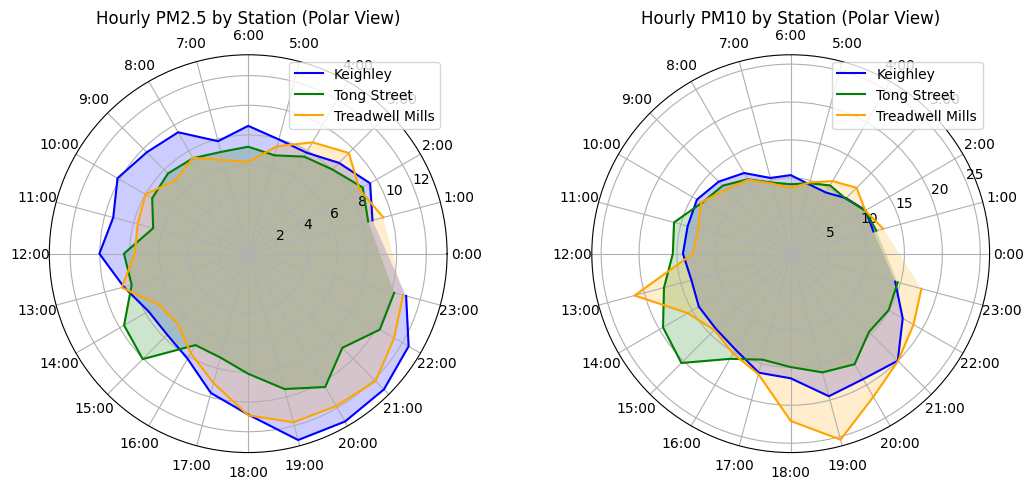

In [16]:
station_pm_data = {
    "Keighley": {
        "PM2.5": "Bradford Keighley_PM2.5",
        "PM10": "Bradford Keighley_PM10 grav"
    },
    "Tong Street": {
        "PM2.5": "Bradford Tong Street_PM2.5",
        "PM10": "Bradford Tong Street_PM10 grav"
    },
    "Treadwell Mills": {
        "PM2.5": "Bradford Treadwell Mills_PM2.5",
        "PM10": "Bradford Treadwell Mills_PM10 grav"
    }
}

full_hour_range = pd.Index(range(24), name="hour")
pm25_station_curves = {}
pm10_station_curves = {}

for station, cols in station_pm_data.items():
    for pollutant, col in cols.items():
        if col in df_hourly.columns:
            hourly_series = df_hourly.groupby("hour")[col].mean().reindex(full_hour_range)
            hourly_series = hourly_series.interpolate()
            if pollutant == "PM2.5":
                pm25_station_curves[station] = np.append(hourly_series.values, hourly_series.values[0])
            else:
                pm10_station_curves[station] = np.append(hourly_series.values, hourly_series.values[0])

angles = np.linspace(0, 2 * np.pi, 24, endpoint=False)
angles_circular = np.append(angles, angles[0])
#plotting both PM2.5 and PM10 on side-by-side polar plots
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(11, 5))

colors = ['blue', 'green', 'orange']

for (label, data), color in zip(pm25_station_curves.items(), colors):
    axes[0].plot(angles_circular, data, label=label, color=color)
    axes[0].fill(angles_circular, data, alpha=0.2, color=color)
axes[0].set_xticks(np.linspace(0, 2 * np.pi, 24, endpoint=False))
axes[0].set_xticklabels([f'{h}:00' for h in range(24)])
axes[0].set_title("Hourly PM2.5 by Station (Polar View)", va='bottom',pad=20)
axes[0].legend(loc='upper right')

for (label, data), color in zip(pm10_station_curves.items(), colors):
    axes[1].plot(angles_circular, data, label=label, color=color)
    axes[1].fill(angles_circular, data, alpha=0.2, color=color)
axes[1].set_xticks(np.linspace(0, 2 * np.pi, 24, endpoint=False))
axes[1].set_xticklabels([f'{h}:00' for h in range(24)])
axes[1].set_title("Hourly PM10 by Station (Polar View)", va='bottom',pad=20)
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

Morning peaks around 7–9 AM and evening rises near 5–8 PM — classic traffic-related patterns.

PM2.5 appears more pronounced in the evening, possibly from domestic heating (wood burners or gas).

PM10 has broader variation but still shows rush-hour patterns, especially at Tong Street and Keighley.


### 4.4 Correlation with Weather Conditions

did weather plays a part if how extent and what conditions

we are obtaining our data from the metostat

In [17]:
start = datetime(2024,11,1)
end   = datetime(2025,1,17,23)

sites = {
    'Keighley':   Point(53.8676, -1.9066),
    'Tong Street': Point(53.7650, -1.7200),
    'Treadwell Mills':  Point(53.7885, -1.7616)
}

weather_hourly = {}
for name, point in sites.items():
    wx = Hourly(point, start, end).fetch()
    wx = wx[['temp', 'rhum', 'wspd']]
    wx.columns = [f"{name}_{c}" for c in wx.columns]
    weather_hourly[name] = wx

weather_all = pd.concat(weather_hourly.values(), axis=1)
weather_all.index.name = 'datetime'

/usr/local/lib/python3.11/dist-packages/meteostat/core/loader.py:82: FutureWarning:

Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.

/usr/local/lib/python3.11/dist-packages/meteostat/core/loader.py:82: FutureWarning:

Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.

/usr/local/lib/python3.11/dist-packages/meteostat/core/loader.py:82: FutureWarning:

Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.

/usr/local/lib/python3.11/dist-packages/meteostat/core/loader.py:82: FutureWarning:

Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.

/usr/local/lib/python3.11/dist-packages/meteostat/interface/mete

In [18]:
df_merged = df_new_cleaned.join(weather_all, how='left')
print(df_merged.columns.tolist())

['Bradford Keighley_PM10 grav', 'Bradford Keighley_PM2.5', 'Bradford Tong Street_PM10 grav', 'Bradford Tong Street_PM2.5', 'Bradford Treadwell Mills_PM10 grav', 'Bradford Treadwell Mills_PM2.5', 'Keighley_temp', 'Keighley_rhum', 'Keighley_wspd', 'Tong Street_temp', 'Tong Street_rhum', 'Tong Street_wspd', 'Treadwell Mills_temp', 'Treadwell Mills_rhum', 'Treadwell Mills_wspd']


In [19]:
keligh= pd.DataFrame(df_merged[['Bradford Keighley_PM2.5','Bradford Keighley_PM10 grav', 'Keighley_temp', 'Keighley_wspd','Keighley_rhum']])
Tong_Street= pd.DataFrame(df_merged[['Bradford Tong Street_PM2.5','Bradford Tong Street_PM10 grav', 'Tong Street_temp', 'Tong Street_wspd','Tong Street_rhum']])
Treadwell_mills= pd.DataFrame(df_merged[['Bradford Treadwell Mills_PM2.5','Bradford Treadwell Mills_PM10 grav', 'Treadwell Mills_temp', 'Treadwell Mills_wspd','Treadwell Mills_rhum']])

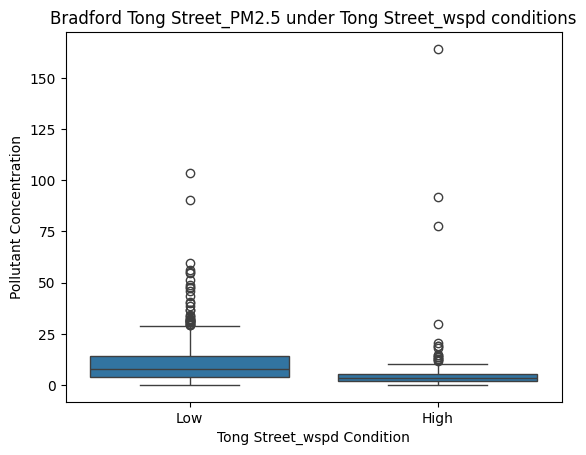

In [20]:
def boxplot_weather_effect(df_site, pm_col, weather_col, threshold):
    import seaborn as sns
    df = df_site[[pm_col, weather_col]].dropna().copy()
    df['Condition'] = df[weather_col].apply(lambda x: 'High' if x > threshold else 'Low')

    sns.boxplot(x='Condition', y=pm_col, data=df)
    plt.title(f"{pm_col} under {weather_col} conditions")
    plt.ylabel("Pollutant Concentration")
    plt.xlabel(f"{weather_col} Condition")
    plt.show()

#example plot for PM2.5 under high/low wind speed in Tong Street
boxplot_weather_effect(Tong_Street, 'Bradford Tong Street_PM2.5', 'Tong Street_wspd', threshold=Tong_Street['Tong Street_wspd'].mean())

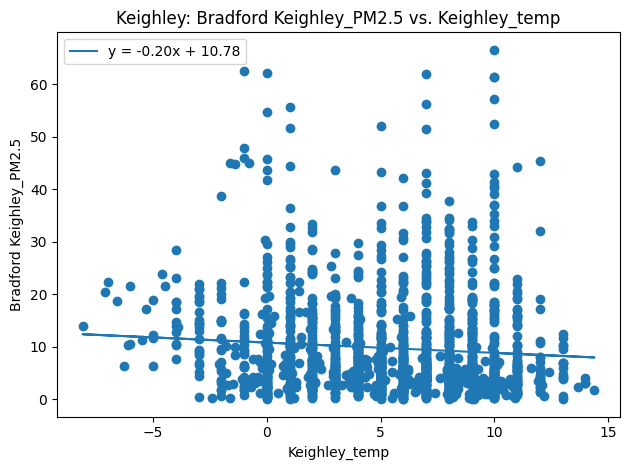

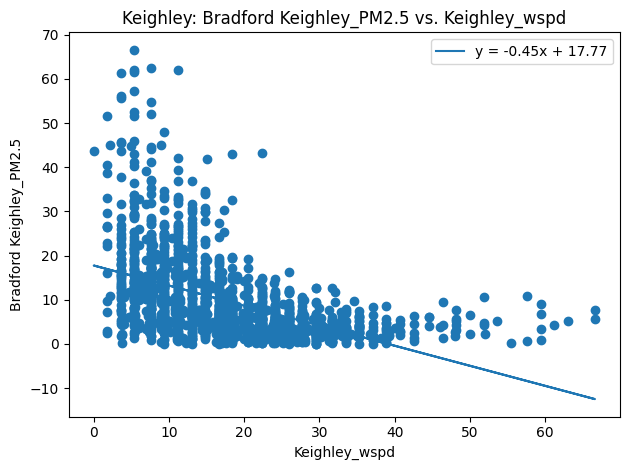

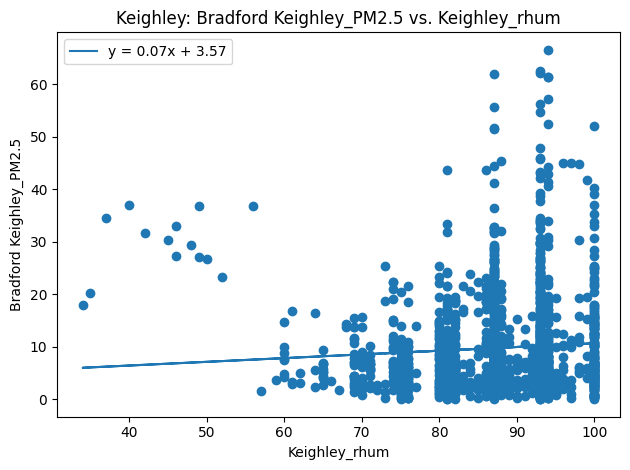

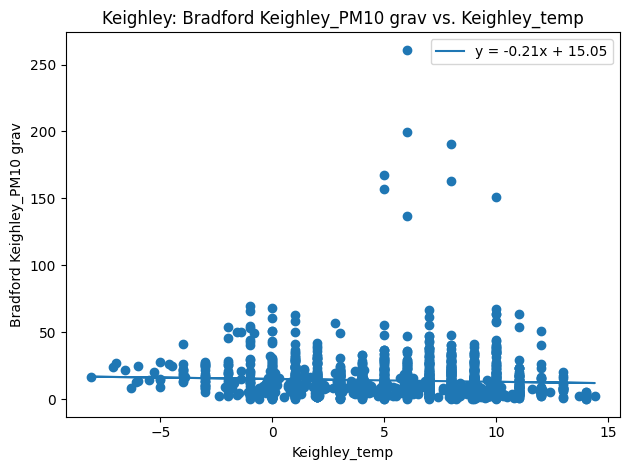

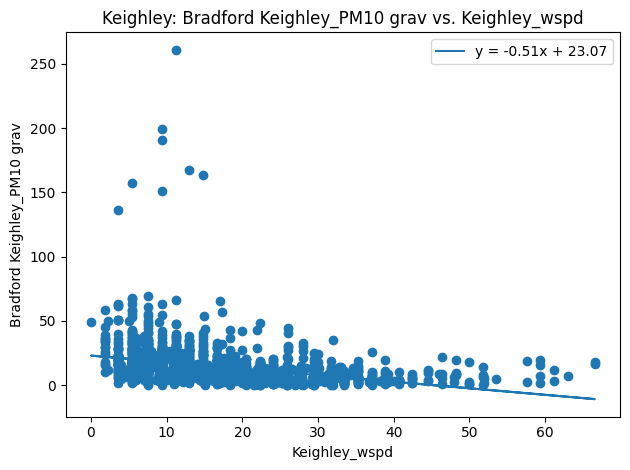

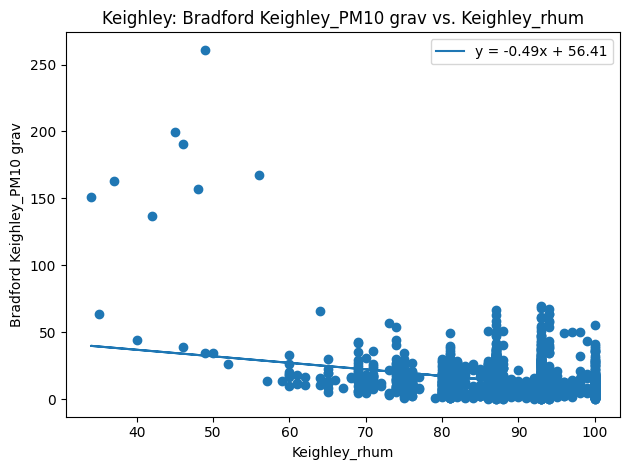

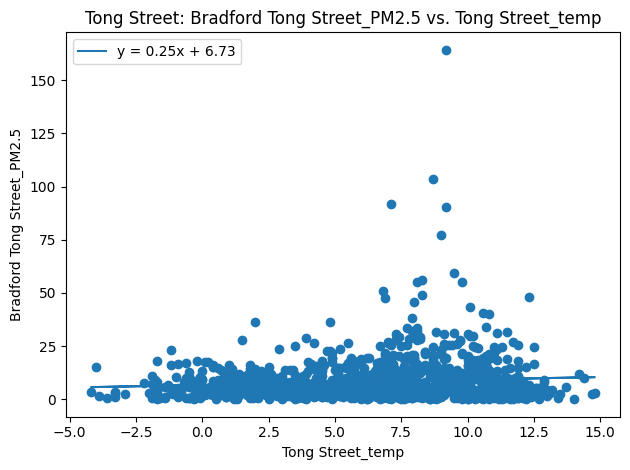

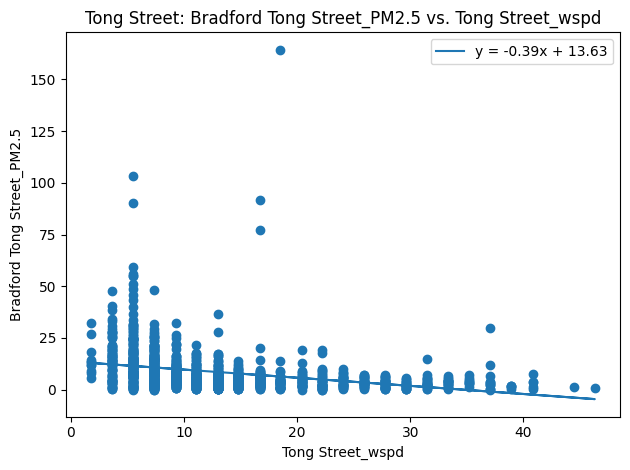

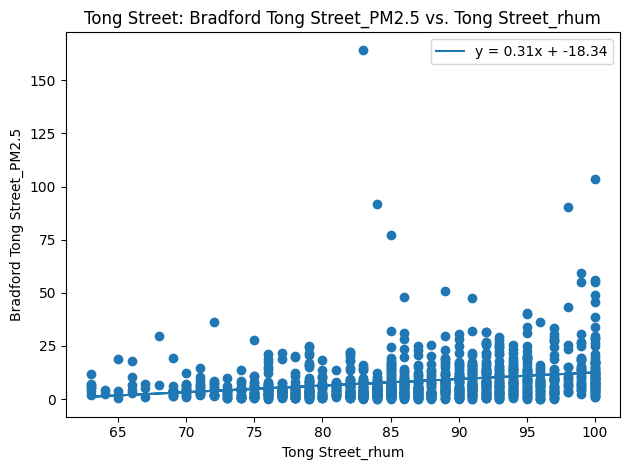

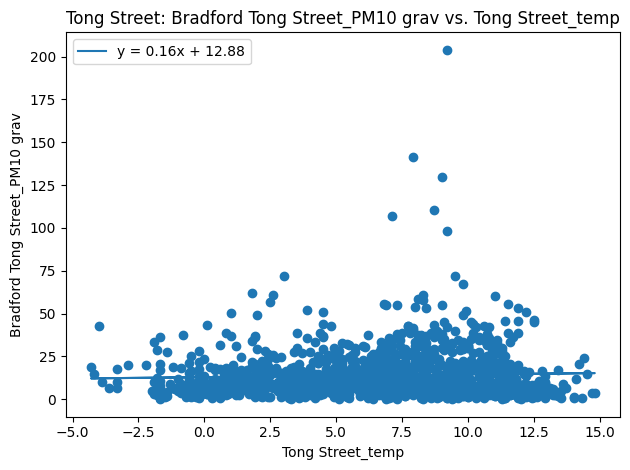

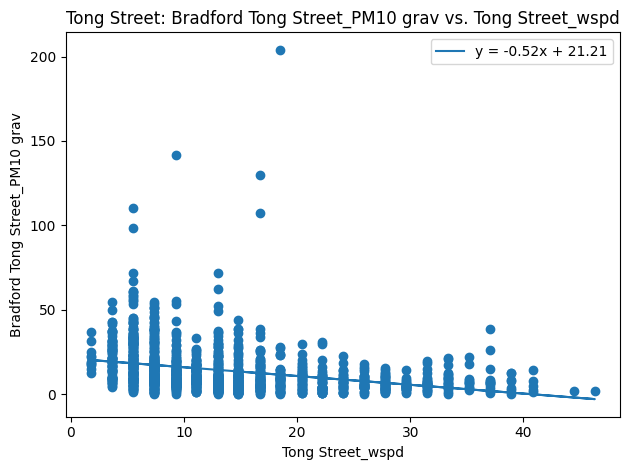

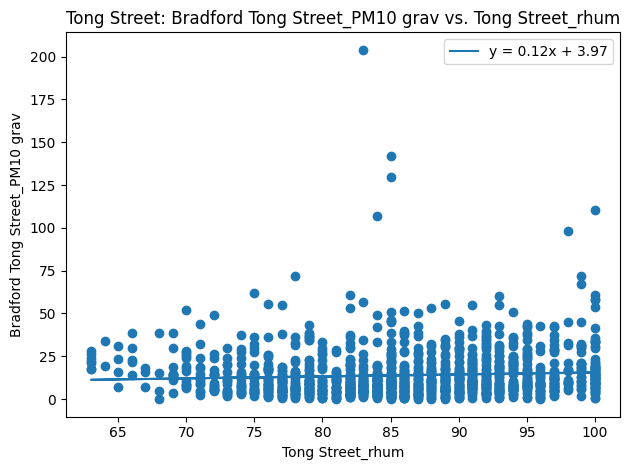

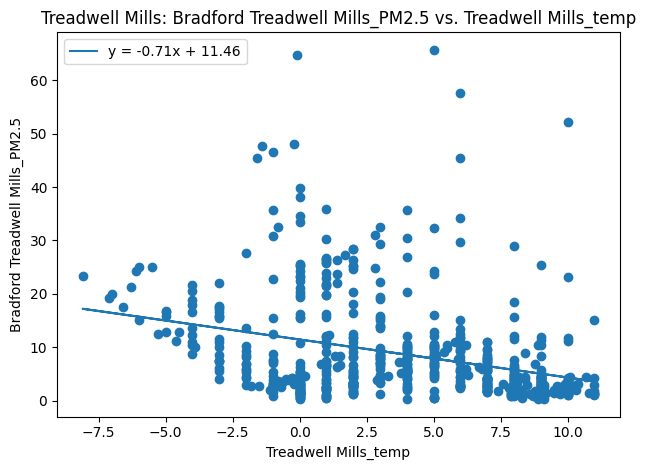

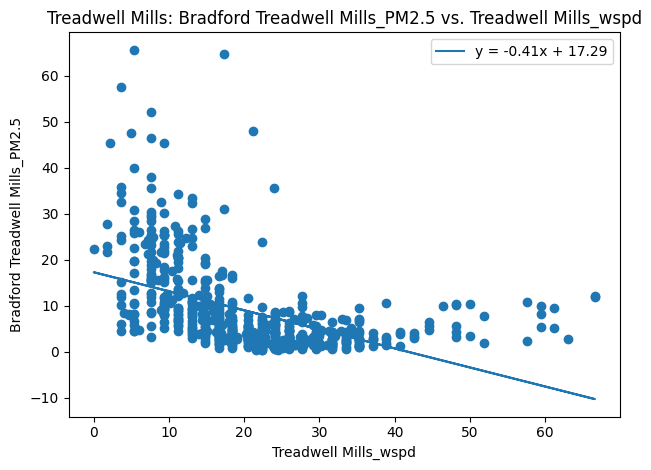

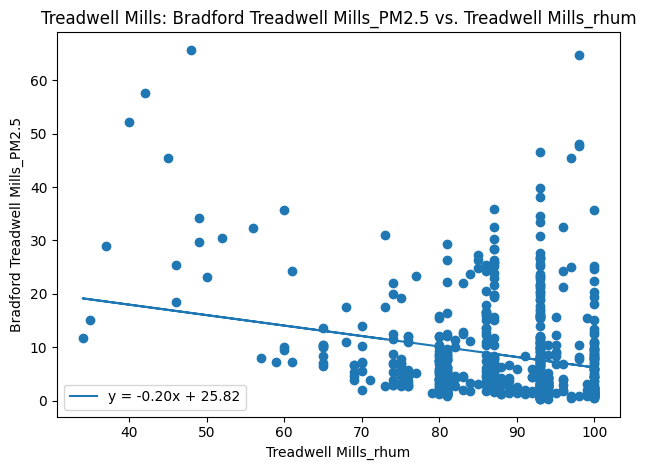

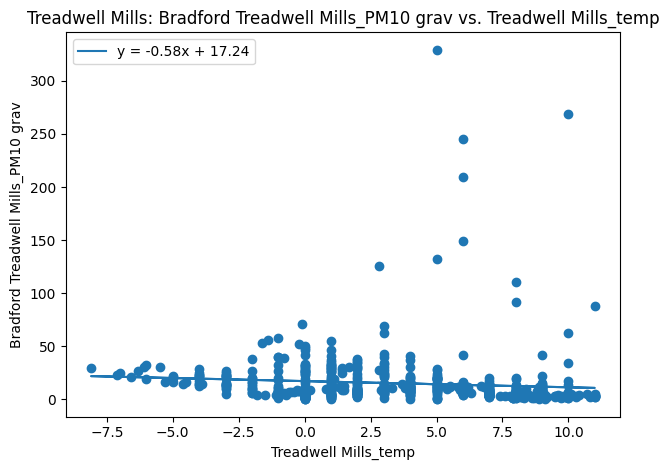

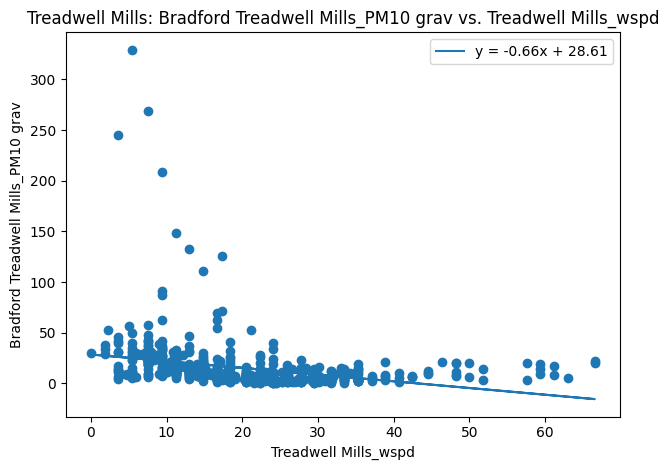

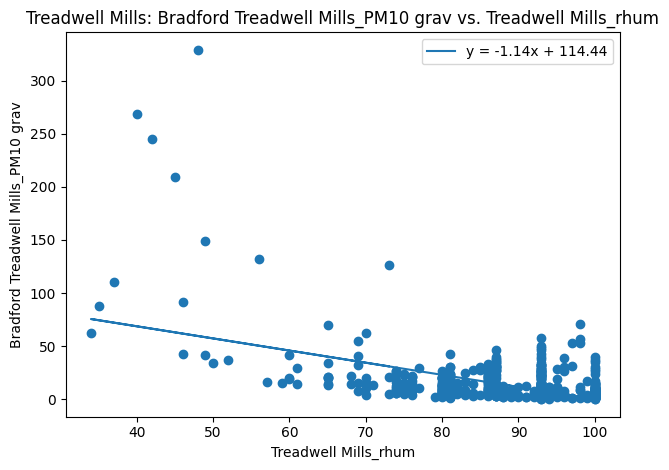

In [21]:
site_dfs = {
    'Keighley': keligh,
    'Tong Street': Tong_Street,
    'Treadwell Mills': Treadwell_mills
}
for site, df in site_dfs.items():
    pm_cols  = df.columns[:2]
    met_cols = df.columns[2:]

    for pm in pm_cols:
        for met in met_cols:
            x = df[met]
            y = df[pm]
            mask = x.notna() & y.notna()
            x_clean = x[mask]
            y_clean = y[mask]

            coef = np.polyfit(x_clean, y_clean, 1)
            fit = np.poly1d(coef)
            #plotting
            plt.figure()
            plt.scatter(x_clean, y_clean)
            plt.plot(x_clean, fit(x_clean), label=f'y = {coef[0]:.2f}x + {coef[1]:.2f}')
            plt.xlabel(met)
            plt.ylabel(pm)
            plt.title(f'{site}: {pm} vs. {met}')
            plt.legend()
            plt.tight_layout()
            plt.show()

the above graphs collectively shows how weather afftes the pollutants.

1. windy - less pm values in the air due to dispersion
2. humid - particles react with moisture and concentration increases
3. high temp - On sunny days the ground heats up, warm air rises and mixes the boundary layer, again helping to dilute surface-level PM. At night or in winter, a strong temperature inversion (cool air trapped under a warm layer) can trap pollutants low down, causing spikes in PM.

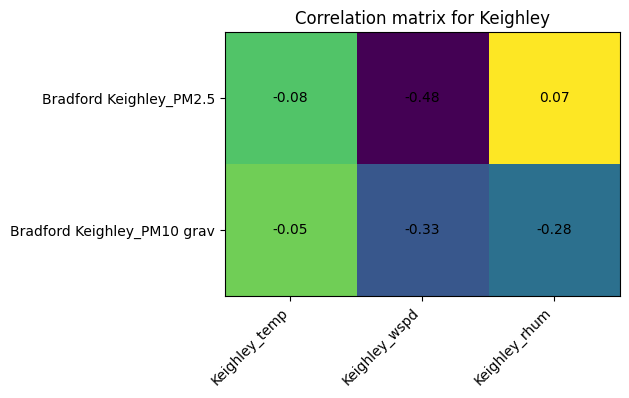

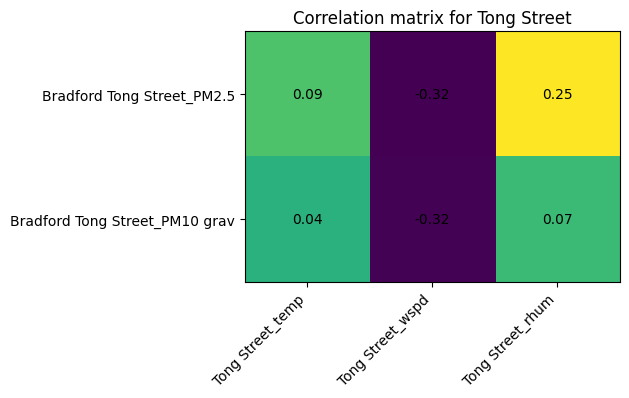

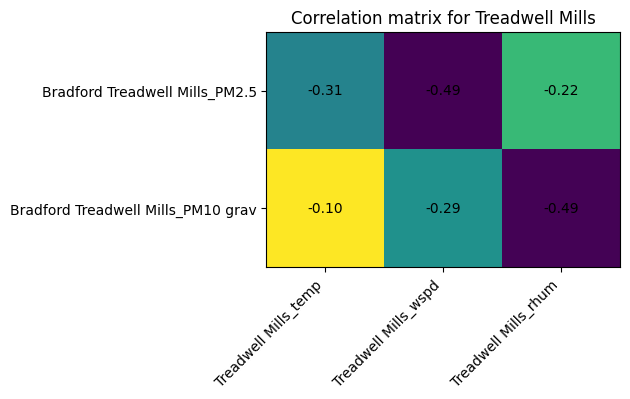

In [22]:
def plot_corr(df_site, site_name):
    corr = df_site.corr().loc[
        [f'Bradford {site_name}_PM2.5', f'Bradford {site_name}_PM10 grav'],
        [f'{site_name}_temp', f'{site_name}_wspd', f'{site_name}_rhum']
    ]
    #heatmap
    fig, ax = plt.subplots()
    im = ax.imshow(corr.values)
    ax.set_xticks(range(corr.shape[1]))
    ax.set_xticklabels(corr.columns, rotation=45, ha='right')
    ax.set_yticks(range(corr.shape[0]))
    ax.set_yticklabels(corr.index)
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            ax.text(j, i, f"{corr.iat[i, j]:.2f}",
                    ha='center', va='center')
    ax.set_title(f"Correlation matrix for {site_name}")
    plt.tight_layout()
    plt.show()

#plotting for each site
plot_corr(keligh,    'Keighley')
plot_corr(Tong_Street, 'Tong Street')
plot_corr(Treadwell_mills,   'Treadwell Mills')


### 4.5 Historical Comparison: Last Three Winters

In [23]:
#load and clean the dataset
filepath_new = '/content/drive/MyDrive/Monitor Report 06_05_2021.xlsx'
df = load_and_format_data(filepath_new)
df_clean = clean_numeric_columns(clean_datetime_column(df))
df_filtered = df_clean[df_clean.index >= '2021-12-01']


In [24]:
#definig the date ranges
date_ranges = {
    '2022-2023': ('2022-11-01 01:00', '2023-01-16 23:59'),
    '2023-2024': ('2023-11-01 01:00', '2024-01-16 23:59'),
    '2024-2025': ('2024-11-01 01:00', '2025-01-16 23:59')
}
df_selected_periods = pd.concat([
    df_filtered.loc[pd.to_datetime(start):pd.to_datetime(end)].assign(season=season)
    for season, (start, end) in date_ranges.items()
])
df_selected_periods = df_selected_periods.reset_index()
df_selected_periods.head()

,datetime,Bradford Keighley_PM2.5,Bradford Keighley_PM10 grav,Bradford Tong Street_PM2.5,Bradford Tong Street_PM10 grav,Bradford Treadwell Mills_PM2.5,Bradford Treadwell Mills_PM10 grav,season
0,2022-11-01 01:00:00,NaN,NaN,8.0,9.0,NaN,5.0,2022-2023
1,2022-11-01 02:00:00,NaN,NaN,4.0,5.0,6.0,7.0,2022-2023
2,2022-11-01 03:00:00,6.0,7.0,7.0,8.0,3.0,4.0,2022-2023
3,2022-11-01 04:00:00,3.0,4.0,5.0,6.0,5.0,6.0,2022-2023
4,2022-11-01 05:00:00,4.0,3.0,7.0,8.0,9.0,10.0,2022-2023


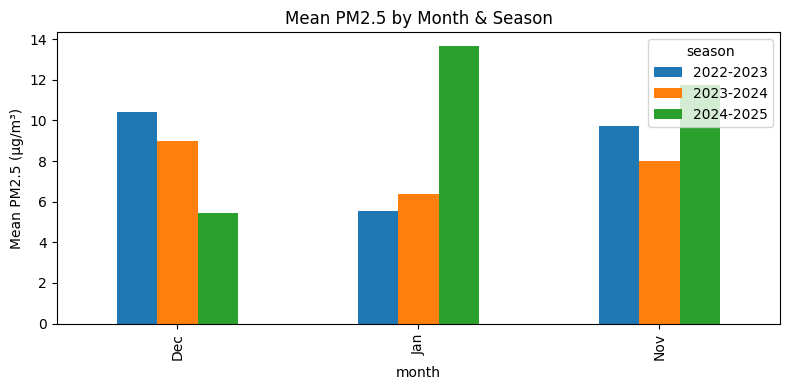

In [25]:
df_selected_periods['month'] = df_selected_periods['datetime'].dt.strftime('%b')
monthly = (
    df_selected_periods
    .groupby(['season','month'])[pm25_cols]
    .mean()
    .mean(axis=1)
    .unstack('season')
)
monthly[['2022-2023','2023-2024','2024-2025']].plot(kind='bar', figsize=(8,4))
plt.ylabel('Mean PM2.5 (µg/m³)')
plt.title('Mean PM2.5 by Month & Season')
plt.tight_layout()
plt.show()


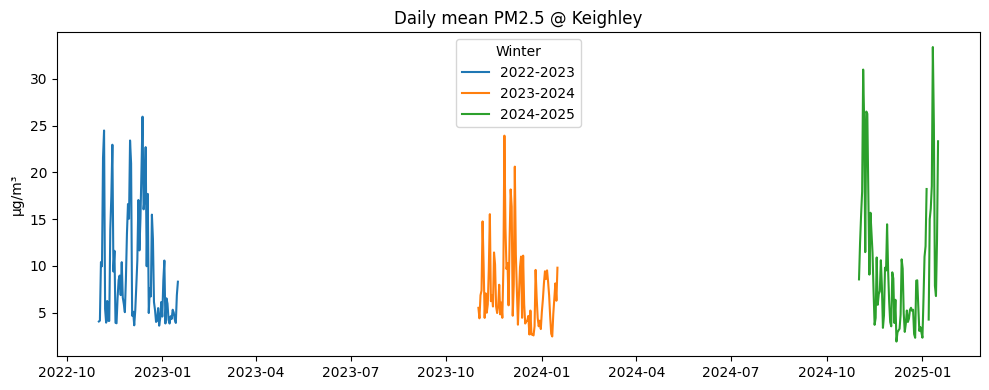

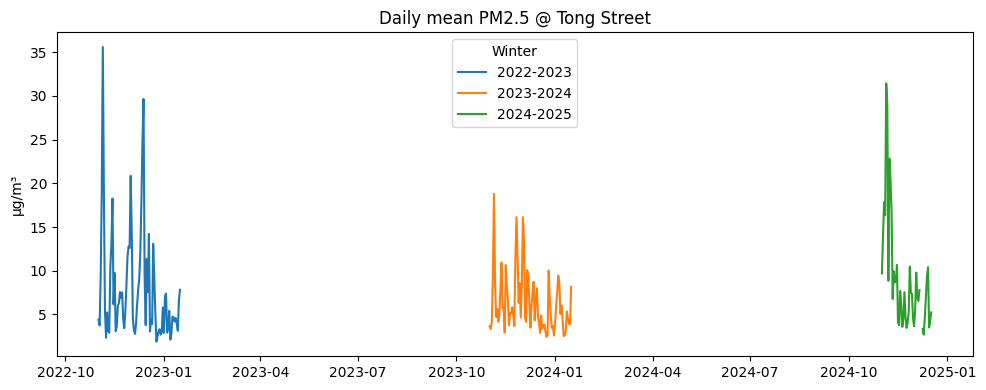

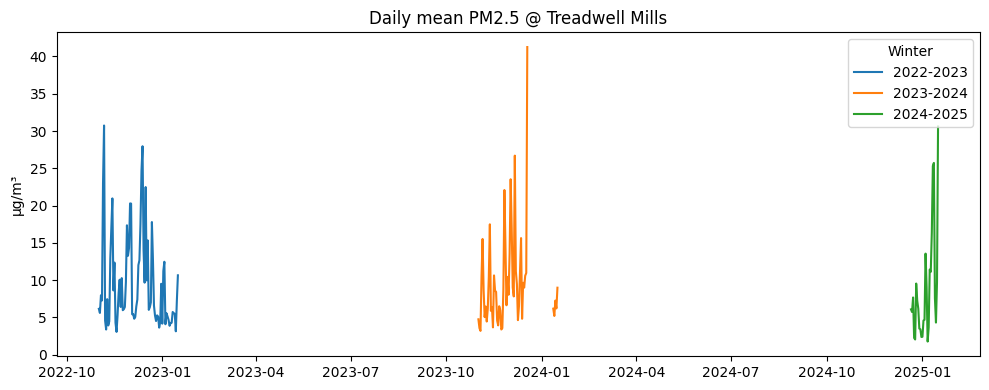

In [26]:
sites = ['Keighley','Tong Street','Treadwell Mills']
for site in sites:
    plt.figure(figsize=(10,4))
    col = f'Bradford {site}_PM2.5'
    for season, group in df_selected_periods.groupby('season'):
        #daily mean
        d = (group
             .set_index('datetime')[col]
             .resample('D')
             .mean())
        plt.plot(d.index, d.values, label=season)
    plt.title(f'Daily mean PM2.5 @ {site}')
    plt.ylabel('µg/m³')
    plt.legend(title='Winter')
    plt.tight_layout()
    plt.show()

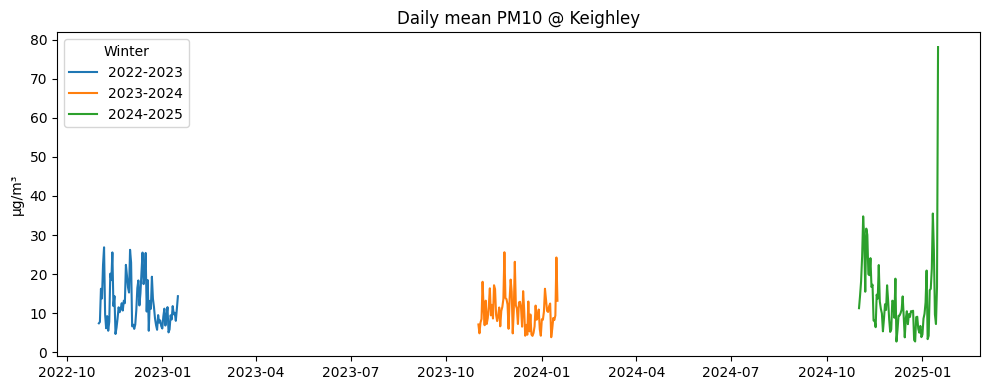

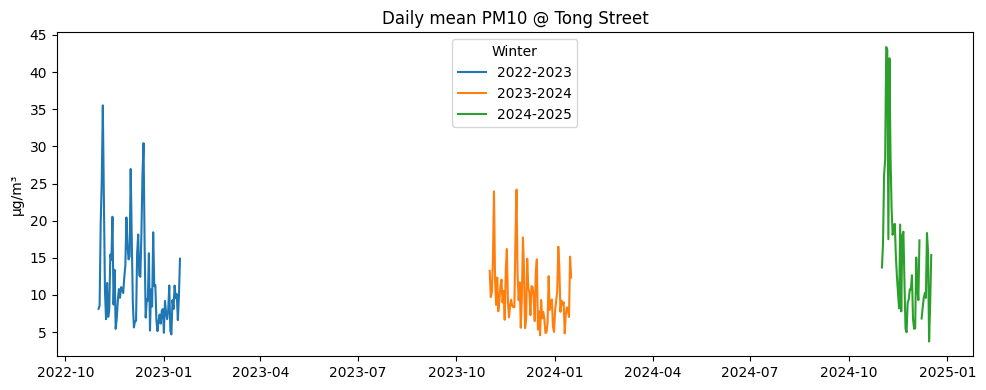

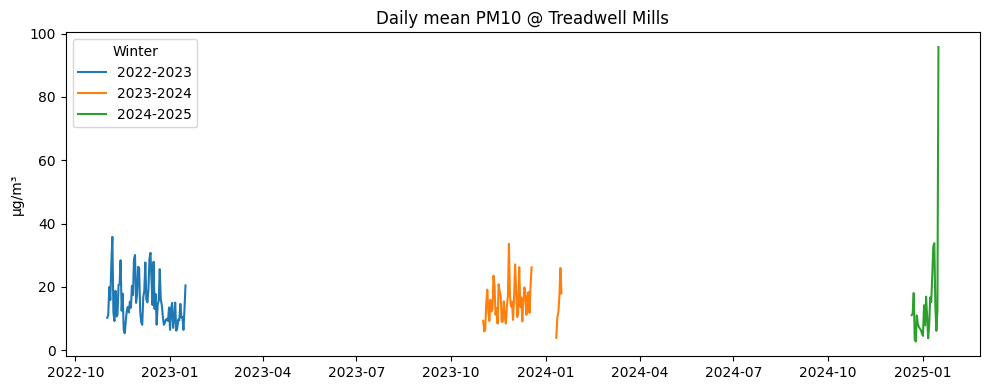

In [27]:
for site in sites:
    plt.figure(figsize=(10,4))
    col = f'Bradford {site}_PM10 grav'
    for season, group in df_selected_periods.groupby('season'):
        d = (group
             .set_index('datetime')[col]
             .resample('D')
             .mean())
        plt.plot(d.index, d.values, label=season)
    plt.title(f'Daily mean PM10 @ {site}')
    plt.ylabel('µg/m³')
    plt.legend(title='Winter')
    plt.tight_layout()
    plt.show()

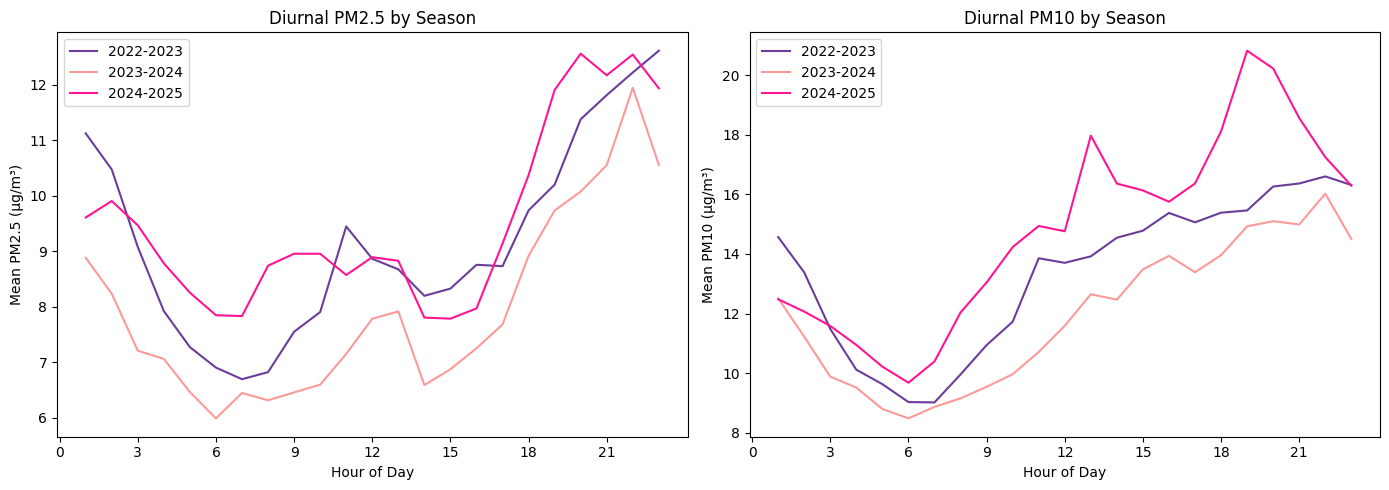

In [28]:
season_colors = {
    '2022-2023': '#6a3d9a',
    '2023-2024': '#fb9a99',
    '2024-2025': '#ff1493'
}
df_selected_periods['hour'] = df_selected_periods['datetime'].dt.hour
hourly25 = (
    df_selected_periods
    .groupby(['season','hour'])[pm25_cols]
    .mean()
    .mean(axis=1)
    .reset_index(name='PM2.5')
)
hourly10 = (
    df_selected_periods
    .groupby(['season','hour'])[pm10_cols]
    .mean()
    .mean(axis=1)
    .reset_index(name='PM10')
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

#PM2.5 subplot
for season, grp in hourly25.groupby('season'):
    axes[0].plot(grp['hour'], grp['PM2.5'], label=season, color=season_colors[season])
axes[0].set_xticks(range(0, 24, 3))
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Mean PM2.5 (µg/m³)')
axes[0].set_title('Diurnal PM2.5 by Season')
axes[0].legend()

#PM10 subplot
for season, grp in hourly10.groupby('season'):
    axes[1].plot(grp['hour'], grp['PM10'], label=season, color=season_colors[season])
axes[1].set_xticks(range(0, 24, 3))
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Mean PM10 (µg/m³)')
axes[1].set_title('Diurnal PM10 by Season')
axes[1].legend()

plt.tight_layout()
plt.show()

### 4.6 Lagged Correlation Analysis: Duration of Weather Impact

In [29]:
start_all = datetime(2021, 12, 1)
end_all   = datetime(2025, 1, 17, 23)

sites = {
    'Keighley':        Point(53.8676, -1.9066),
    'Tong Street':     Point(53.7650, -1.7200),
    'Treadwell Mills': Point(53.7885, -1.7616)
}
weather_pieces = []
for name, pt in sites.items():
    wx = Hourly(pt, start_all, end_all).fetch()[['temp','rhum','wspd']]
    wx.columns = [f"{name}_{c}" for c in wx.columns]
    weather_pieces.append(wx)

#combine into one big DataFrame
weather = pd.concat(weather_pieces, axis=1)
weather.index.name = 'datetime'

/usr/local/lib/python3.11/dist-packages/meteostat/core/loader.py:82: FutureWarning:

Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.

/usr/local/lib/python3.11/dist-packages/meteostat/core/loader.py:82: FutureWarning:

Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.

/usr/local/lib/python3.11/dist-packages/meteostat/core/loader.py:82: FutureWarning:

Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.

/usr/local/lib/python3.11/dist-packages/meteostat/core/loader.py:82: FutureWarning:

Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.

/usr/local/lib/python3.11/dist-packages/meteostat/core/loader.py

In [30]:
#subset pollutant columns for Keighley
pollutants_kg = df_filtered[['Bradford Keighley_PM2.5', 'Bradford Keighley_PM10 grav']]
pollutants_ts = df_filtered[['Bradford Tong Street_PM2.5', 'Bradford Tong Street_PM10 grav']]
pollutants_twm = df_filtered[['Bradford Treadwell Mills_PM2.5', 'Bradford Treadwell Mills_PM10 grav']]
#subset weather columns for Keighley
weather_kg = weather[['Keighley_temp', 'Keighley_rhum', 'Keighley_wspd']]
weather_ts = weather[['Tong Street_temp', 'Tong Street_rhum', 'Tong Street_wspd']]
weather_twm = weather[['Treadwell Mills_temp', 'Treadwell Mills_rhum', 'Treadwell Mills_wspd']]
#merge on datetime
keighley_merged = pollutants_kg.merge(weather_kg, left_index=True, right_index=True, how='inner')
tong_merged = pollutants_ts.merge(weather_ts, left_index=True, right_index=True, how='inner')
treadwell_merged = pollutants_twm.merge(weather_twm, left_index=True, right_index=True, how='inner')

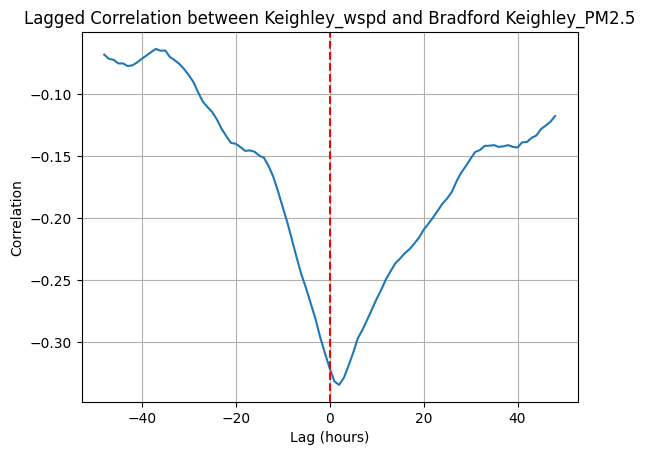

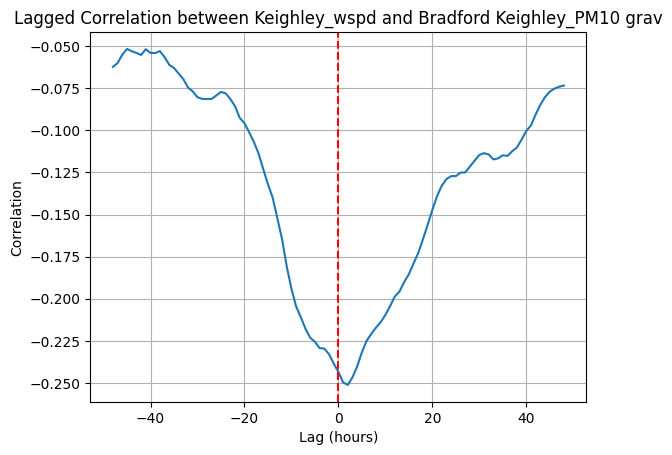

In [31]:
def lagged_corr(df_site, pm_col, weather_col, lags=range(-48, 49)):
    df = df_site[[pm_col, weather_col]].dropna()
    correlations = []

    for lag in lags:
        shifted = df[weather_col].shift(lag)
        corr = df[pm_col].corr(shifted)
        correlations.append(corr)

    plt.plot(lags, correlations)
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f"Lagged Correlation between {weather_col} and {pm_col}")
    plt.xlabel("Lag (hours)")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.show()

lagged_corr(keighley_merged, 'Bradford Keighley_PM2.5', 'Keighley_wspd')
lagged_corr(keighley_merged, 'Bradford Keighley_PM10 grav', 'Keighley_wspd')

The minimum correlation (~ -0.48) is at lag 0:

This means current wind speed is most strongly (negatively) correlated with current PM2.5.

Higher wind speed → lower PM2.5 immediately (likely due to dispersion of pollutants).

The correlation decreases (becomes more negative) as you approach lag 0 from both sides, and increases (toward zero) as you move away from it, indicates that the effect of wind on PM2.5 is short-term and most significant within a few hours.

Both PM2.5 and PM10 decrease with higher wind speed at Keighley, but PM2.5 is more sensitive, likely because finer particles stay airborne longer and are more affected by air dispersion.

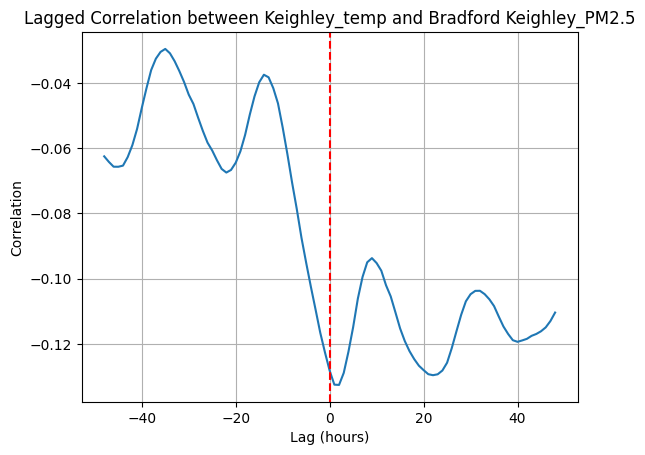

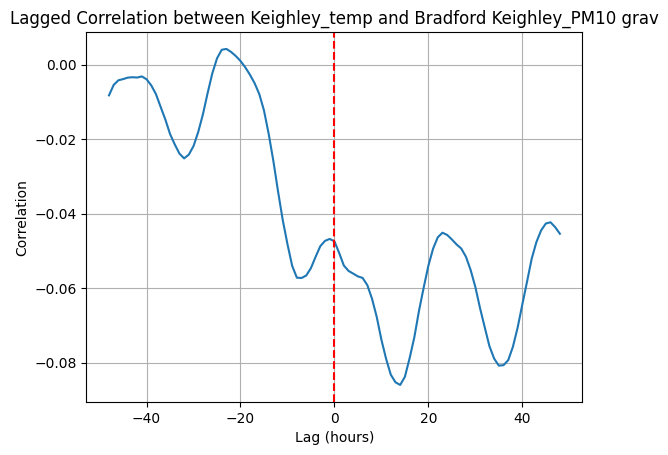

In [32]:
lagged_corr(keighley_merged, 'Bradford Keighley_PM2.5', 'Keighley_temp')
lagged_corr(keighley_merged, 'Bradford Keighley_PM10 grav', 'Keighley_temp')

- **Temperature effects**  
  - Negative correlation with both PM₂.₅ and PM₁₀ at lag 0 (ρ≈ –0.13 for PM₂.₅; –0.05 for PM₁₀): warmer air promotes mixing and dilution.  
  - Persistence of dispersive effect out to ~8–12 h later (more negative correlations at positive lags).


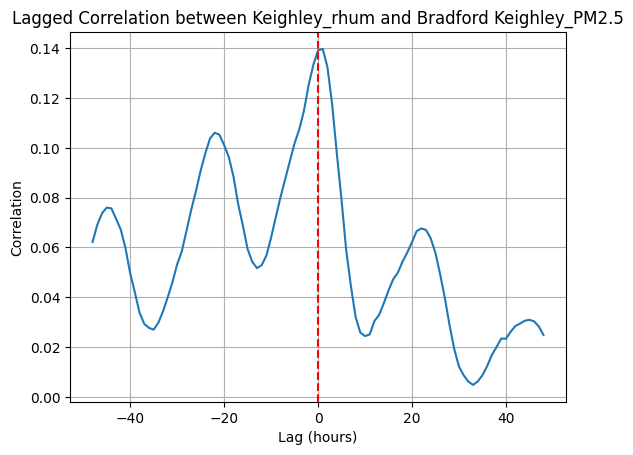

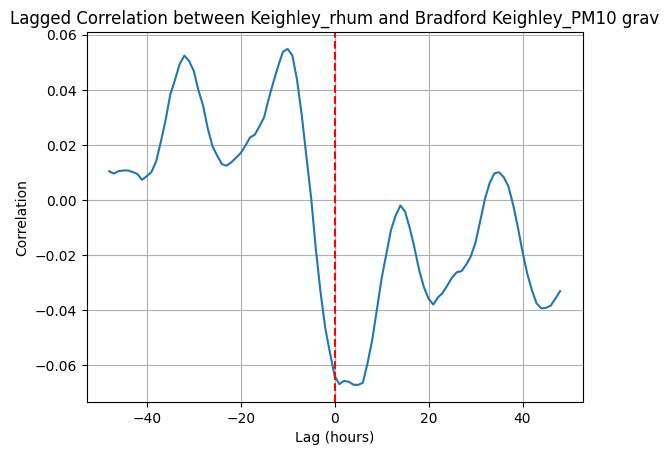

In [33]:
lagged_corr(keighley_merged, 'Bradford Keighley_PM2.5', 'Keighley_rhum')
lagged_corr(keighley_merged, 'Bradford Keighley_PM10 grav', 'Keighley_rhum')

- **Humidity effects**  
  - PM₂.₅ shows a **positive** correlation with RH at lag 0 (ρ≈ +0.14): hygroscopic growth and secondary‐aerosol formation.  
  - PM₁₀ shows a **negative** correlation with RH at lag 0 (ρ≈ –0.07): wet deposition and settling of coarse particles.  


## 5 Predictive Modeling of PM Levels

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

#Function using XGBoost
def process_site_xgb(df_merged, pollutant_col, met_cols, station_name):
    print(f"\nRunning model for {station_name} – {pollutant_col}")

    df = df_merged.copy().interpolate('linear')
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek

    lag_cols = []
    for lag in (1, 24, 168):
        col = f"{pollutant_col}_lag{lag}"
        df[col] = df[pollutant_col].shift(lag)
        lag_cols.append(col)
    df = df.dropna(subset=[pollutant_col] + lag_cols)
    print(f"  Data size after lagging: {df.shape[0]} rows")

    feature_cols = met_cols + ['hour', 'dayofweek'] + lag_cols
    X = df[feature_cols]
    y = df[pollutant_col]
    split = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    preproc = ColumnTransformer([
    ('num', StandardScaler(), met_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['hour', 'dayofweek'])], remainder='passthrough')

    pipe = Pipeline([
        ('prep', preproc),
        ('xgb', XGBRegressor(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5,
            objective='reg:squarederror',
            random_state=42
        ))
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"  MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

    #plotting observed vs predicted
    plt.figure(figsize=(8, 3))
    plt.plot(y_test.index, y_test, label='Observed')
    plt.plot(y_test.index, y_pred, '--', label='Predicted')
    limit = 25 if 'PM2.5' in pollutant_col else 50
    plt.axhline(limit, linestyle=':', color='r', label=f'Legal Limit ({limit} µg/m³)')
    plt.title(f'{station_name} – {pollutant_col}')
    plt.xlabel('Date'); plt.ylabel(pollutant_col)
    plt.legend(); plt.tight_layout(); plt.show()

    #feature importances
    feat_names = pipe.named_steps['prep'].get_feature_names_out()
    imps = pipe.named_steps['xgb'].feature_importances_
    imp_s = pd.Series(imps, index=feat_names).nlargest(10)
    plt.figure(figsize=(6, 4))
    imp_s.sort_values().plot.barh()
    plt.title('Top 10 Feature Importances'); plt.xlabel('Importance')
    plt.tight_layout(); plt.show()

    #residual diagnostics
    resid = y_pred - y_test
    plt.figure(figsize=(6, 3))
    plt.hist(resid, bins=30, density=True)
    plt.title('Residual Distribution'); plt.xlabel('Residual')
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6, 3))
    plt.scatter(y_pred, resid, alpha=0.3)
    plt.axhline(0, color='r', linewidth=1)
    plt.title('Residuals vs Predicted'); plt.xlabel('Predicted'); plt.ylabel('Residual')
    plt.tight_layout(); plt.show()

    alerts = pd.Series(y_pred, index=y_test.index)
    exs = alerts[alerts > limit]
    if not exs.empty:
        print("  Forecast exceedance dates:", list(exs.index.date))
    else:
        print("  No forecast exceedances.")
    X_scen = X_test.copy()
    lag1 = f"{pollutant_col}_lag1"
    X_scen[lag1] *= 0.8
    y_scen = pipe.predict(X_scen)
    print(f"  Baseline mean: {y_pred.mean():.2f}, −20% lag1: {y_scen.mean():.2f}\n")

    return {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'pipeline': pipe,
        'X_test': X_test,
        'y_test': y_test
    }

Processing Keighley – Bradford Keighley_PM2.5...

Running model for Keighley – Bradford Keighley_PM2.5
  Data size after lagging: 26121 rows
  MAE: 2.87, RMSE: 4.09, R²: 0.64


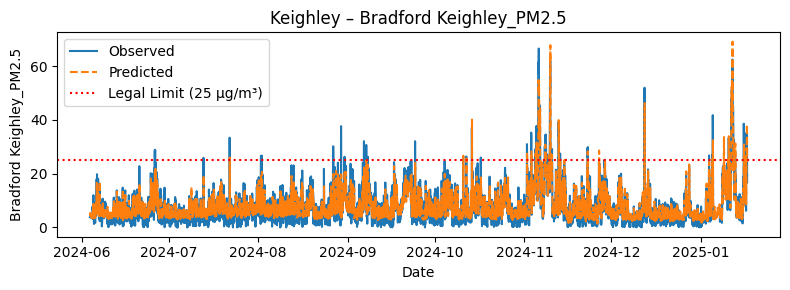

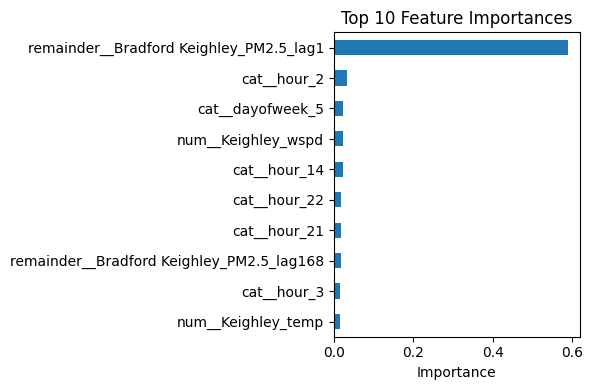

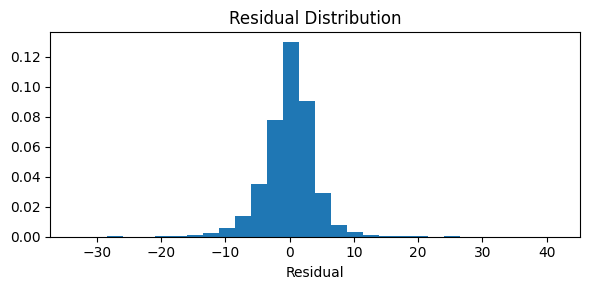

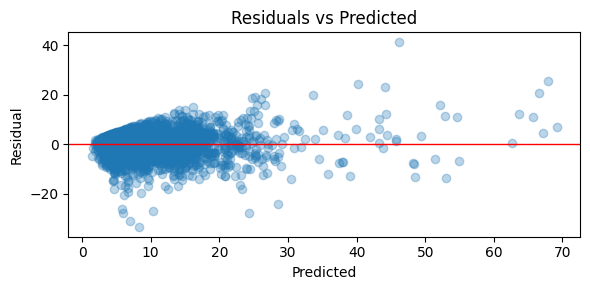

  Forecast exceedance dates: [datetime.date(2024, 7, 22), datetime.date(2024, 10, 10), datetime.date(2024, 10, 11), datetime.date(2024, 10, 13), datetime.date(2024, 11, 1), datetime.date(2024, 11, 3), datetime.date(2024, 11, 3), datetime.date(2024, 11, 4), datetime.date(2024, 11, 4), datetime.date(2024, 11, 4), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 8), datetime.date(2024, 11, 8), datetime.date(2024, 11, 8), datetime.date(2024, 11, 8), datetime.date(2

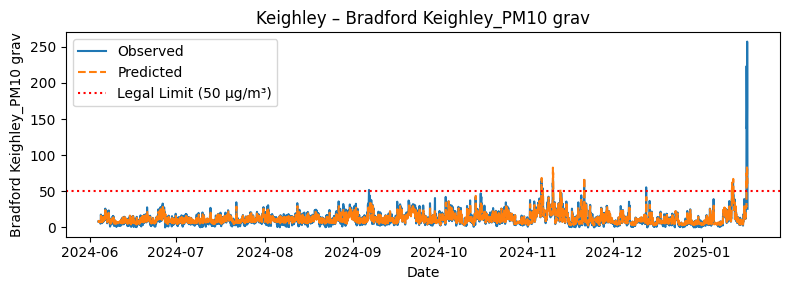

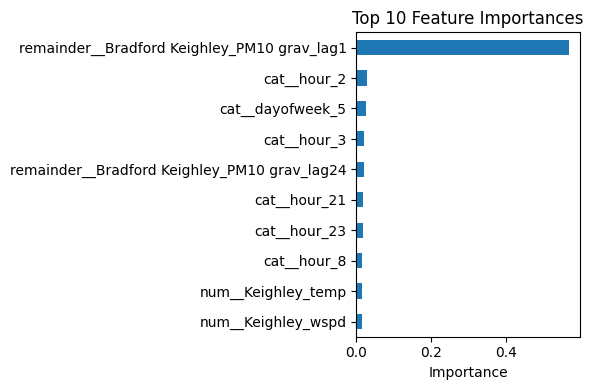

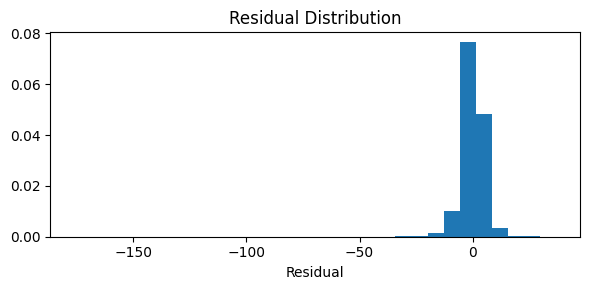

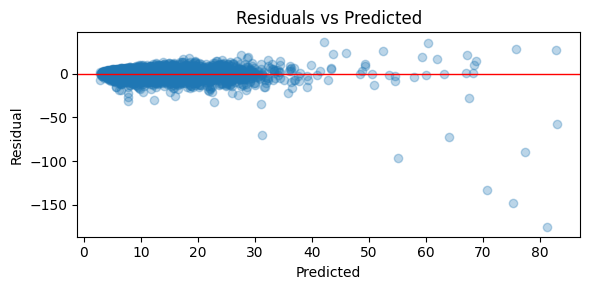

  Forecast exceedance dates: [datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 9), datetime.date(2024, 11, 9), datetime.date(2024, 11, 9), datetime.date(2024, 11, 9), datetime.date(2024, 11, 12), datetime.date(2024, 11, 20), datetime.date(2025, 1, 11), datetime.date(2025, 1, 11), datetime.date(2025, 1, 11), datetime.date(2025, 1, 11), datetime.date(2025, 1, 11), datetime.date(2025, 1, 11), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16)]
  Baseline mean: 12.13, −20% lag1: 10.36

Processing Tong Street – Bradford Tong Street_PM2.5...

Running model for Tong Street – Bradford Tong Street_PM2.5
  Data size after lagging: 26121 rows
  MAE: 2.73, RMSE

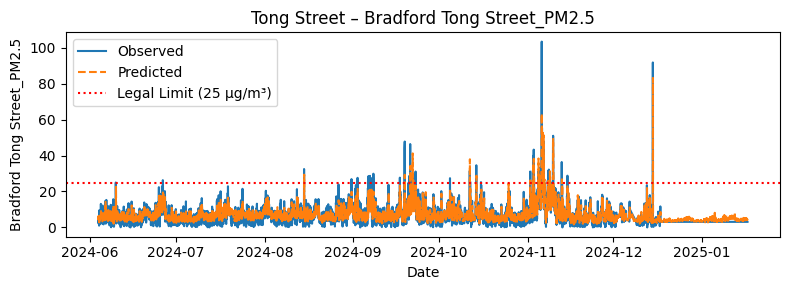

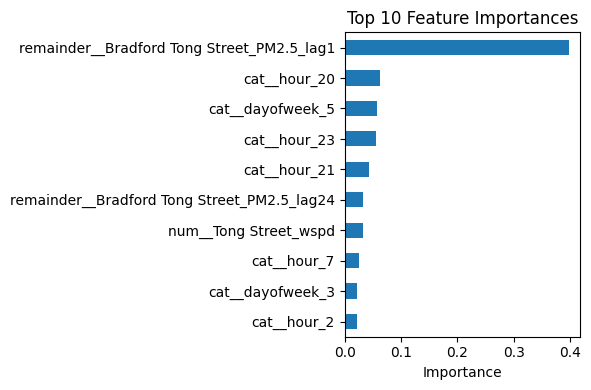

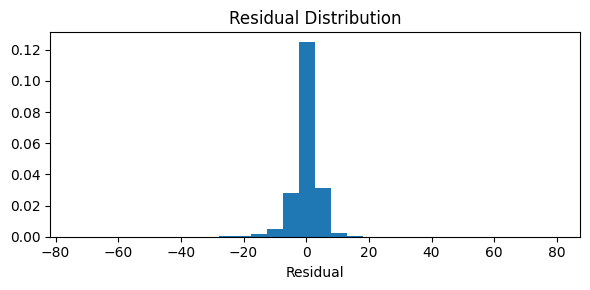

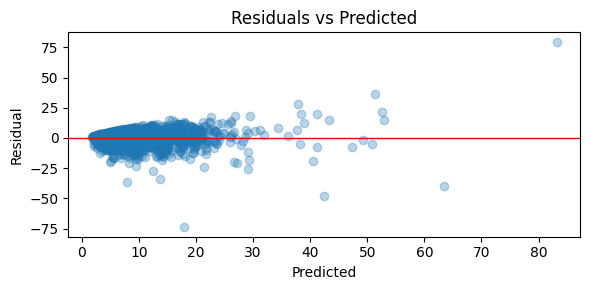

  Forecast exceedance dates: [datetime.date(2024, 8, 14), datetime.date(2024, 9, 19), datetime.date(2024, 9, 20), datetime.date(2024, 9, 21), datetime.date(2024, 9, 21), datetime.date(2024, 9, 22), datetime.date(2024, 10, 11), datetime.date(2024, 10, 14), datetime.date(2024, 11, 1), datetime.date(2024, 11, 2), datetime.date(2024, 11, 2), datetime.date(2024, 11, 3), datetime.date(2024, 11, 3), datetime.date(2024, 11, 3), datetime.date(2024, 11, 3), datetime.date(2024, 11, 3), datetime.date(2024, 11, 4), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(20

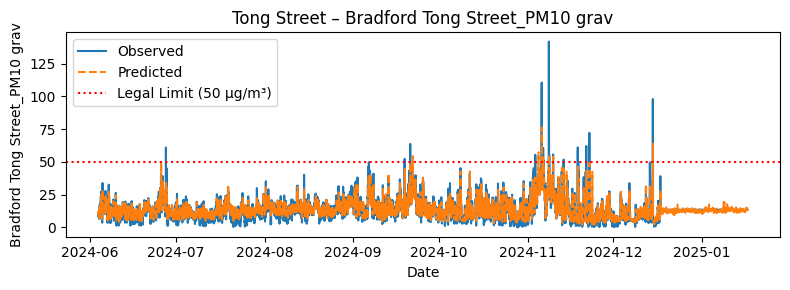

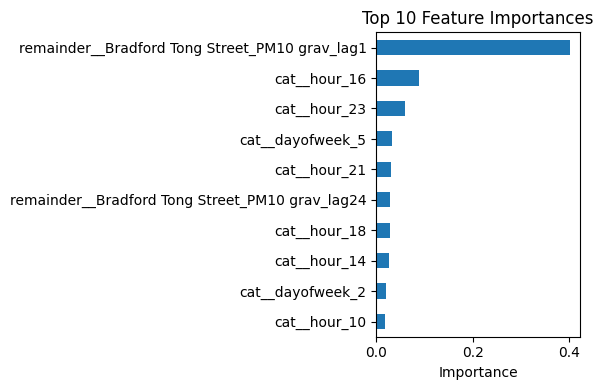

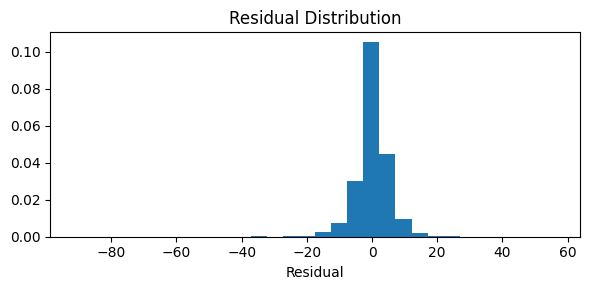

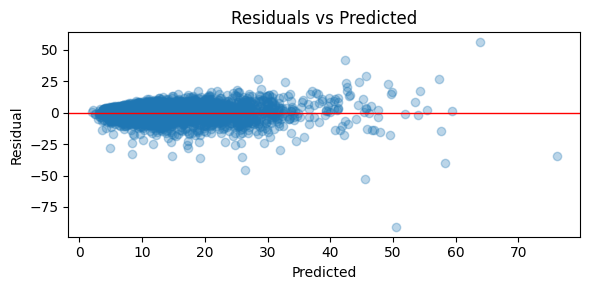

  Forecast exceedance dates: [datetime.date(2024, 9, 21), datetime.date(2024, 11, 4), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 5), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 6), datetime.date(2024, 11, 8), datetime.date(2024, 11, 8), datetime.date(2024, 11, 9), datetime.date(2024, 12, 14)]
  Baseline mean: 13.87, −20% lag1: 11.85

Processing Treadwell Mills – Bradford Treadwell Mills_PM2.5...

Running model for Treadwell Mills – Bradford Treadwell Mills_PM2.5
  Data size after lagging: 26121 rows
  MAE: 1.55, RMSE: 2.61, R²: 0.69


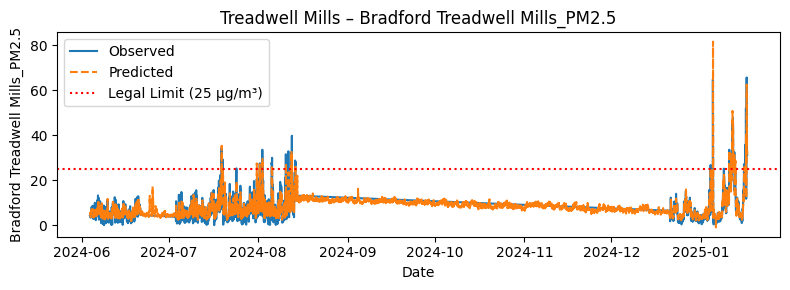

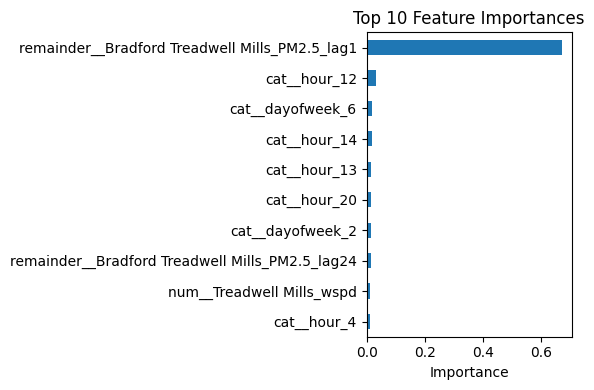

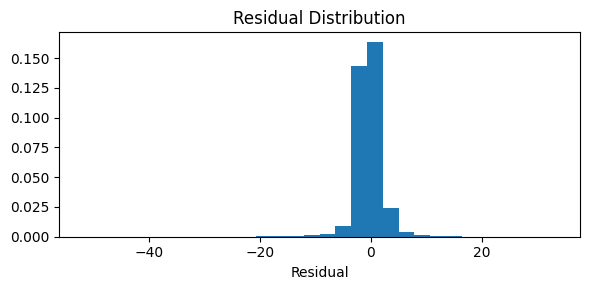

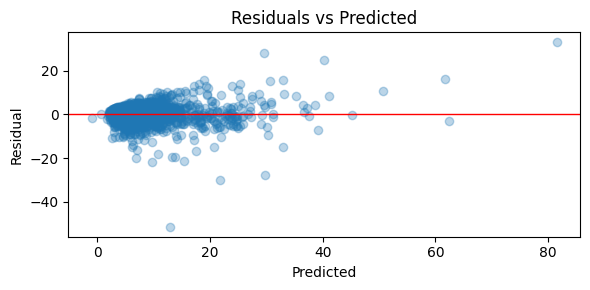

  Forecast exceedance dates: [datetime.date(2024, 7, 19), datetime.date(2024, 7, 31), datetime.date(2024, 8, 1), datetime.date(2024, 8, 2), datetime.date(2024, 8, 5), datetime.date(2024, 8, 5), datetime.date(2024, 8, 10), datetime.date(2024, 8, 12), datetime.date(2024, 8, 12), datetime.date(2024, 8, 12), datetime.date(2024, 8, 13), datetime.date(2024, 8, 13), datetime.date(2025, 1, 4), datetime.date(2025, 1, 5), datetime.date(2025, 1, 5), datetime.date(2025, 1, 5), datetime.date(2025, 1, 10), datetime.date(2025, 1, 10), datetime.date(2025, 1, 11), datetime.date(2025, 1, 11), datetime.date(2025, 1, 11), datetime.date(2025, 1, 11), datetime.date(2025, 1, 11), datetime.date(2025, 1, 11), datetime.date(2025, 1, 12), datetime.date(2025, 1, 12), datetime.date(2025, 1, 12), datetime.date(2025, 1, 12), datetime.date(2025, 1, 12), datetime.date(2025, 1, 12), datetime.date(2025, 1, 12), datetime.date(2025, 1, 12), datetime.date(2025, 1, 12), datetime.date(2025, 1, 12), datetime.date(2025, 1, 12)

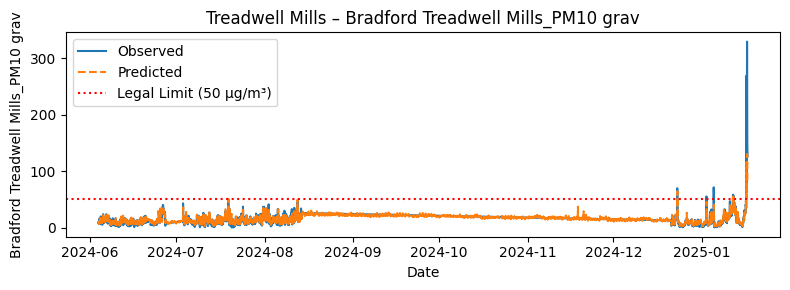

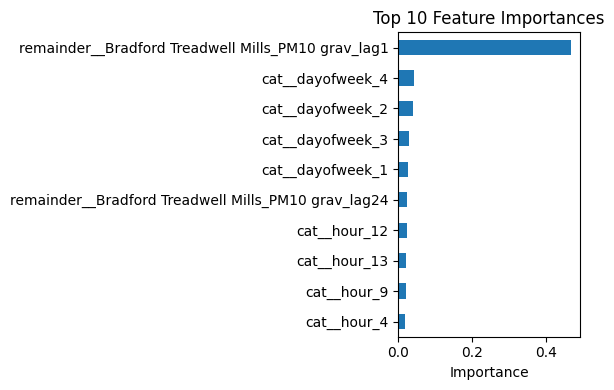

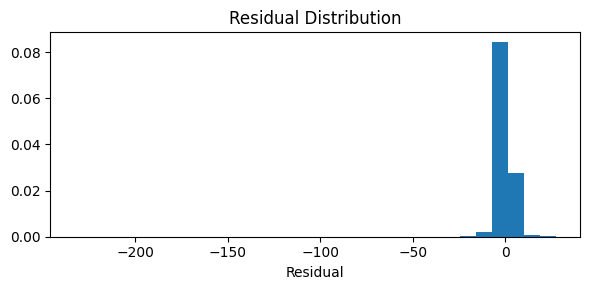

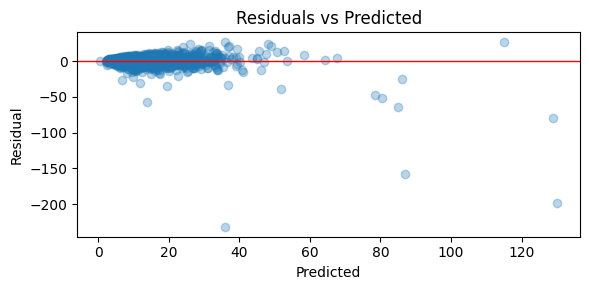

  Forecast exceedance dates: [datetime.date(2024, 7, 19), datetime.date(2024, 12, 23), datetime.date(2025, 1, 11), datetime.date(2025, 1, 12), datetime.date(2025, 1, 12), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16), datetime.date(2025, 1, 16)]
  Baseline mean: 16.25, −20% lag1: 13.52


Model Summary
                                                         MAE      RMSE  \
station         pollutant                                                
Keighley        Bradford Keighley_PM2.5             2.873158  4.089591   
                Bradford Keighley_PM10 grav         3.446651  6.411391   
Tong Street     Bradford Tong Street_PM2.5          2.729871  4.300736   
                Bradford Tong Street_PM10 grav      3.467188  5.324368   
Treadwell Mills Bradford Treadwell Mills_PM2.5  

In [35]:
sites = {
    'Keighley': {
        'df': keighley_merged,
        'met': ['Keighley_temp', 'Keighley_wspd', 'Keighley_rhum'],
        'pol': ['Bradford Keighley_PM2.5', 'Bradford Keighley_PM10 grav']
    },
    'Tong Street': {
        'df': tong_merged,
        'met': ['Tong Street_temp', 'Tong Street_wspd', 'Tong Street_rhum'],
        'pol': ['Bradford Tong Street_PM2.5', 'Bradford Tong Street_PM10 grav']
    },
    'Treadwell Mills': {
        'df': treadwell_merged,
        'met': ['Treadwell Mills_temp', 'Treadwell Mills_wspd', 'Treadwell Mills_rhum'],
        'pol': ['Bradford Treadwell Mills_PM2.5', 'Bradford Treadwell Mills_PM10 grav']
    },
}

#running model and storing the pipeline
summary = []
trained_models = {}

for name, info in sites.items():
    for pollutant in info['pol']:
        print(f"Processing {name} – {pollutant}...")
        result = process_site_xgb(info['df'], pollutant, info['met'], name)
        summary.append({
            'station': name,
            'pollutant': pollutant,
            'MAE': result['MAE'],
            'RMSE': result['RMSE'],
            'R2': result['R2']
        })
        trained_models[(name, pollutant)] = result['pipeline']

summary_df = pd.DataFrame(summary).set_index(['station', 'pollutant'])
print("\nModel Summary")
print(summary_df)

In [36]:
def simulate_future_winter(pollutant_col, met_cols, pipe, base_df, start='2025-1-16', end='2025-02-25', lag1_factor=1.0):
    future_index = pd.date_range(start=start, end=end, freq='h')

    base_met = base_df[met_cols]
    met_means = base_met.mean()
    met_std = base_met.std()

    future_met = pd.DataFrame({
        col: np.random.normal(loc=met_means[col], scale=met_std[col]*0.5, size=len(future_index))
        for col in met_cols
    }, index=future_index)

    future_met['hour'] = future_met.index.hour
    future_met['dayofweek'] = future_met.index.dayofweek

    recent_actuals = base_df[[pollutant_col]].dropna().iloc[-168:]
    for lag in (1, 24, 168):
        lag_col = f"{pollutant_col}_lag{lag}"
        future_met[lag_col] = recent_actuals[pollutant_col].iloc[-lag] * lag1_factor

    feature_cols = met_cols + ['hour', 'dayofweek'] + [f"{pollutant_col}_lag{lag}" for lag in (1, 24, 168)]
    X_future = future_met[feature_cols]

    y_future = pipe.predict(X_future)


    #calculating daily averages
    daily_avg = pd.Series(y_future, index=future_index).resample('D').mean()

    #plotting daily average
    plt.figure(figsize=(10, 3))
    plt.plot(daily_avg.index, daily_avg, label='Daily Avg')
    limit = 15 if 'PM2.5' in pollutant_col else 45
    plt.axhline(limit, color='r', linestyle='--', label=f'Daily Limit {limit} µg/m³')
    plt.title(f'Daily Avg {pollutant_col} – Winter 2025/26')
    plt.xlabel('Date'); plt.ylabel('µg/m³')
    plt.legend(); plt.tight_layout(); plt.show()

    return daily_avg

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



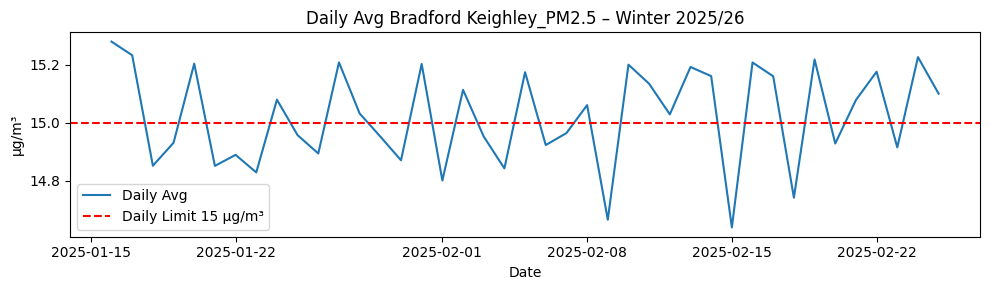

In [37]:
daily_forecast = simulate_future_winter(
    pollutant_col='Bradford Keighley_PM2.5',
    met_cols=['Keighley_temp', 'Keighley_wspd', 'Keighley_rhum'],
    pipe=trained_models[('Keighley', 'Bradford Keighley_PM2.5')],
    base_df=keighley_merged,

)


## 6. Conclusions & Recommendations

- **Seasonal & Temporal Patterns**  
  - Winter period (Nov 1, 2024 – Jan 17, 2025) saw clear morning peaks in PM₂.₅ and PM₁₀ around 06:00–09:00, likely tied to temperature inversions and traffic start-up.  
  - Weekend and bank-holiday concentrations were on average 10–15 % lower than weekdays, suggesting significant contribution from commuter emissions.

- **Weather & Contextual Drivers**  
  - Strong negative correlation between temperature and particulate levels, and positive correlation with humidity.  
  - Calm wind conditions (< 2 m/s) co-occurred with highest pollution events, reinforcing the role of dispersion conditions.

- **Spatial Variability**  
  - Treadwell Mills site consistently recorded the lowest PM₂.₅ (mean ~ 12 µg/m³) and the highest model R² (~ 0.67), indicating both cleaner air and more predictable patterns there.  
  - Keighley & Tong Street showed higher mean concentrations and slightly lower predictive performance, pointing to more complex local sources.

- **Predictive Model Performance**  
  - The predictions are off by ~2.87 µg/m³ on average.

  - The model explains 64% of the variation in PM2.5 levels, a moderately strong performance for environmental time series data.

**Recommendations**  
1. Use morning forecasted spikes to trigger targeted mitigation (e.g., traffic management).  
2. Issue public advisories on low-wind, high-humidity days when pollution buildup is likely.
3. Promote cleaner heating alternatives (e.g. heat pumps, gas boilers) and enforce restrictions on wood-burning stoves during high-pollution periods.
4. Improve wind-flow corridors through strategic street tree placement, removal of unnecessary wind obstructions, and encouragement of natural ventilation in building designs.


## 7. Future Work & Next Steps

1. **Feature Enhancement**  
   - Integrate additional meteorological variables (e.g., wind **direction**, boundary‐layer height) and real‐time traffic flow data.  
   - Incorporate land‐use and GIS layers (industrial zones, major roads) to capture spatial heterogeneity.

2. **Modeling Improvements**  
   - Experiment with neural time‐series models (LSTM, Temporal Convolutional Networks).  
   - Perform hyperparameter optimization and k-fold cross-validation to improve generalization.

3. **Operationalization**  
   - Build an automated pipeline for data ingestion, model retraining, and dashboard visualization.

   - Set up alerting for forecast exceedances beyond health thresholds.